In [1]:
MAX_SENTENCES = 10
MAX_SENTENCE_LENGTH = 25

In [2]:
# refer: http://ai.stanford.edu/~amaas/data/sentiment/

import os

data_dir = "./datasets/aclImdb"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

def load_dataset(split='train'):
    x_data = []
    y_data = []
    
    base_dir = './datasets/aclImdb'
    split_dir = os.path.join(base_dir, split)
    for sentiment, y in [('neg', 0), ('pos', 1)]:
        data_dir = os.path.join(split_dir, sentiment)
        for file_name in os.listdir(data_dir):
            file_path = os.path.join(data_dir, file_name)
            with open(file_path, 'r', encoding='utf-8') as fp:
                review = fp.read()
            x_data.append(review)
            y_data.append(y)
            
    return x_data, y_data
            
train_x_data, train_y_data = load_dataset(split='train')
test_x_data, test_y_data = load_dataset(split='test')

print("len(train_x_data): {}".format(len(train_x_data)))
print("len(test_x_data): {}".format(len(test_x_data)))

len(train_x_data): 25000
len(test_x_data): 25000


In [3]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.tokenize import sent_tokenize

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x_data)
tokenizer.fit_on_texts(test_x_data)

max_nb_words = len(tokenizer.word_index) + 1

def doc2hierarchical(text,
                     max_sentences=MAX_SENTENCES,
                     max_sentence_length=MAX_SENTENCE_LENGTH):
    sentences = sent_tokenize(text)
    tokenized_sentences = tokenizer.texts_to_sequences(sentences)
    tokenized_sentences = pad_sequences(tokenized_sentences, maxlen=max_sentence_length)

    pad_size = max_sentences - tokenized_sentences.shape[0]

    if pad_size <= 0:  # tokenized_sentences.shape[0] < max_sentences
        tokenized_sentences = tokenized_sentences[:max_sentences]
    else:
        tokenized_sentences = np.pad(
            tokenized_sentences, ((0, pad_size), (0, 0)),
            mode='constant', constant_values=0
        )
    
    return tokenized_sentences
            
def build_dataset(x_data, y_data, 
                  max_sentences=MAX_SENTENCES, 
                  max_sentence_length=MAX_SENTENCE_LENGTH,
                  tokenizer=tokenizer):
    
    nb_instances = len(x_data)
    X_data = np.zeros((nb_instances, max_sentences, max_sentence_length), dtype='int32')
    for i, review in enumerate(x_data):
        tokenized_sentences = doc2hierarchical(review)
            
        X_data[i] = tokenized_sentences[None, ...]
        
    nb_classes = len(set(y_data))
    Y_data = to_categorical(y_data, nb_classes)
    
    return X_data, Y_data

train_X_data, train_Y_data = build_dataset(train_x_data, train_y_data)
test_X_data, test_Y_data = build_dataset(test_x_data, test_y_data)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("test_X_data.shape: {}".format(test_X_data.shape))

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


train_X_data.shape: (25000, 10, 25)
test_X_data.shape: (25000, 10, 25)


In [4]:
from sklearn.model_selection import train_test_split
train_X_data, val_X_data, train_Y_data, val_Y_data = train_test_split(train_X_data, train_Y_data, 
                                                                      test_size=0.1, 
                                                                      random_state=42)

print("train_X_data.shape: {}".format(train_X_data.shape))
print("train_Y_data.shape: {}".format(train_Y_data.shape))
print("val_X_data.shape: {}".format(val_X_data.shape))
print("val_Y_data.shape: {}".format(val_Y_data.shape))

train_X_data.shape: (22500, 10, 25)
train_Y_data.shape: (22500, 2)
val_X_data.shape: (2500, 10, 25)
val_Y_data.shape: (2500, 2)


In [5]:
embedding_dir = './embeddings/'

def load_word2vec(tokenizer=tokenizer):
    from gensim.models import KeyedVectors
    embedding_path = os.path.join(embedding_dir, 'GoogleNews-vectors-negative300.bin')
    embeddings_index = KeyedVectors.load_word2vec_format(embedding_path, binary=True)
    
    return embeddings_index
    
def load_embedding(embedding_type='word2vec',
                   tokenizer=tokenizer,
                   embedding_dim=300):
    
    if embedding_type == 'word2vec':
        embeddings_index = load_word2vec()
        
    embedding_matrix = np.random.normal(0, 1, (max_nb_words, embedding_dim))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = embeddings_index[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

embedding_matrix = load_embedding('word2vec')

print("embedding_matrix.shape: {}".format(embedding_matrix.shape))

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


embedding_matrix.shape: (124253, 300)


In [6]:
import keras
from keras import backend as K
from keras.engine.topology import Layer

from keras.layers import Input, Embedding, Dense
from keras.layers import Lambda, Permute, RepeatVector, Multiply
from keras.layers import Bidirectional, TimeDistributed
from keras.layers import CuDNNGRU
from keras.layers import BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint

class AttentionLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='Attention_Weight',
                                 shape=(input_shape[-1], self.attention_dim),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='Attention_Bias',
                                 shape=(self.attention_dim, ),
                                 initializer='random_normal',
                                 trainable=True)
        self.u = self.add_weight(name='Attention_Context_Vector',
                                 shape=(self.attention_dim, 1),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # refer to the original paper
        # link: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
        u_it = K.tanh(K.dot(x, self.W) + self.b)
        a_it = K.dot(u_it, self.u)
        a_it = K.squeeze(a_it, -1)
        a_it = K.softmax(a_it)
        
        return a_it
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    

def WeightedSum(attentions, representations):
    # from Shape(batch_size, len_units) to Shape(batch_size, rnn_dim * 2, len_units)
    repeated_attentions = RepeatVector(K.int_shape(representations)[-1])(attentions)
    # from Shape(batch_size, rnn_dim * 2, len_units) to Shape(batch_size, len_units, lstm_dim * 2)
    repeated_attentions = Permute([2, 1])(repeated_attentions)

    # compute representation as the weighted sum of representations
    aggregated_representation = Multiply()([representations, repeated_attentions])
    aggregated_representation = Lambda(lambda x: K.sum(x, axis=1))(aggregated_representation)

    return aggregated_representation
    
    
def HieAtt(embedding_matrix,
           max_sentences,
           max_sentence_length,
           nb_classes,
           embedding_dim=300,
           attention_dim=100,
           rnn_dim=150,
           include_dense_batch_normalization=False,
           include_dense_dropout=True,
           nb_dense=1,
           dense_dim=300,
           dense_dropout=0.2,
           optimizer = keras.optimizers.Adam(lr=0.001)):

    # embedding_matrix = (max_nb_words + 1, embedding_dim)
    max_nb_words = embedding_matrix.shape[0] - 1
    embedding_layer = Embedding(max_nb_words + 1, 
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sentence_length,
                                trainable=False)

    # first, build a sentence encoder
    sentence_input = Input(shape=(max_sentence_length, ), dtype='int32')
    embedded_sentence = embedding_layer(sentence_input)
    embedded_sentence = Dropout(dense_dropout)(embedded_sentence)
    contextualized_sentence = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_sentence)
    
    # word attention computation
    word_attention = AttentionLayer(attention_dim)(contextualized_sentence)
    sentence_representation = WeightedSum(word_attention, contextualized_sentence)
    
    sentence_encoder = Model(inputs=[sentence_input], 
                             outputs=[sentence_representation])

    # then, build a document encoder
    document_input = Input(shape=(max_sentences, max_sentence_length), dtype='int32')
    embedded_document = TimeDistributed(sentence_encoder)(document_input)
    contextualized_document = Bidirectional(CuDNNGRU(rnn_dim, return_sequences=True))(embedded_document)
    
    # sentence attention computation
    sentence_attention = AttentionLayer(attention_dim)(contextualized_document)
    document_representation = WeightedSum(sentence_attention, contextualized_document)
    
    # finally, add fc layers for classification
    fc_layers = Sequential()
    for _ in range(nb_dense):
        if include_dense_batch_normalization == True:
            fc_layers.add(BatchNormalization())
        fc_layers.add(Dense(dense_dim, activation='relu'))
        if include_dense_dropout == True:
            fc_layers.add(Dropout(dense_dropout))
    fc_layers.add(Dense(nb_classes, activation='softmax'))
    
    pred_sentiment = fc_layers(document_representation)

    model = Model(inputs=[document_input],
                  outputs=[pred_sentiment])
    
    ############### build attention extractor ###############
    word_attention_extractor = Model(inputs=[sentence_input],
                                     outputs=[word_attention])
    word_attentions = TimeDistributed(word_attention_extractor)(document_input)
    attention_extractor = Model(inputs=[document_input],
                                     outputs=[word_attentions, sentence_attention])
    
    model.compile(loss=['categorical_crossentropy'],
              optimizer=optimizer,
              metrics=['accuracy'])

    return model, attention_extractor


model_name = "HieAtt"
model_path = './models/checkpoints/{}.h5'.format(model_name)
checkpointer = ModelCheckpoint(filepath=model_path,
                               monitor='val_acc',
                               verbose=True,
                               save_best_only=True,
                               mode='max')

model, attention_extractor = HieAtt(embedding_matrix=embedding_matrix,
                                    max_sentences=MAX_SENTENCES,
                                    max_sentence_length=MAX_SENTENCE_LENGTH,
                                    nb_classes=2,
                                    embedding_dim=300,
                                    attention_dim=100,
                                    rnn_dim=150,
                                    include_dense_batch_normalization=False,
                                    include_dense_dropout=True,
                                    nb_dense=1,
                                    dense_dim=300,
                                    dense_dropout=0.2,
                                    optimizer = keras.optimizers.Adam(lr=0.001))

history = model.fit(x=[train_X_data],
                    y=[train_Y_data],
                    batch_size=128,
                    epochs=30,
                    verbose=True,
                    validation_data=(val_X_data, val_Y_data),
                    callbacks=[checkpointer])

Train on 22500 samples, validate on 2500 samples
Epoch 1/30
22500/22500 [==============================] - 9s 388us/step - loss: 0.5270 - acc: 0.7200 - val_loss: 0.3939 - val_acc: 0.8276

Epoch 00001: val_acc improved from -inf to 0.82760, saving model to ./models/checkpoints/HieAtt.h5
Epoch 2/30
22500/22500 [==============================] - 6s 284us/step - loss: 0.3692 - acc: 0.8375 - val_loss: 0.3546 - val_acc: 0.8408

Epoch 00002: val_acc improved from 0.82760 to 0.84080, saving model to ./models/checkpoints/HieAtt.h5
Epoch 3/30
22500/22500 [==============================] - 6s 284us/step - loss: 0.3370 - acc: 0.8545 - val_loss: 0.3445 - val_acc: 0.8496

Epoch 00003: val_acc improved from 0.84080 to 0.84960, saving model to ./models/checkpoints/HieAtt.h5
Epoch 4/30
22500/22500 [==============================] - 6s 283us/step - loss: 0.3117 - acc: 0.8671 - val_loss: 0.3292 - val_acc: 0.8600

Epoch 00004: val_acc improved from 0.84960 to 0.86000, saving model to ./models/checkpoints/

In [7]:
model.load_weights(model_path)
score = model.evaluate(test_X_data, test_Y_data, verbose=0, batch_size=128)
print("Test Accuracy of {}: {}".format(model_name, score[1]))

Test Accuracy of HieAtt: 0.868160000038147


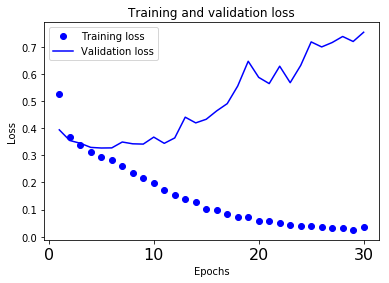

In [12]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

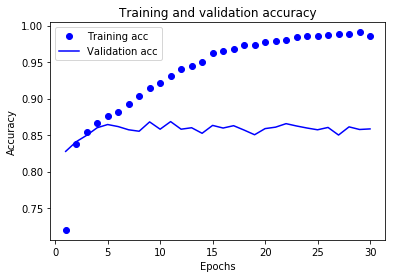

In [9]:
plt.clf()
acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10, 25)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 10, 300)      37712900    input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 10, 300)      406800      time_distributed_1[0][0]         
__________________________________________________________________________________________________
attention_layer_2 (AttentionLay (None, 10)           30200       bidirectional_2[0][0]            
__________________________________________________________________________________________________
repeat_vec

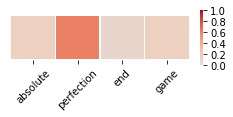

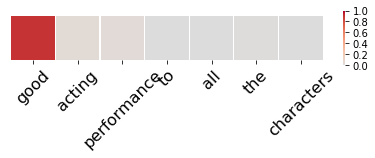

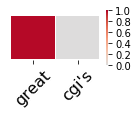

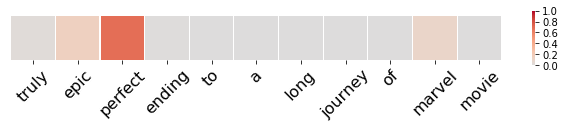

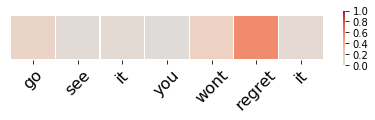

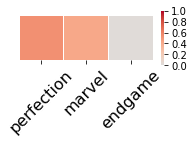

In [11]:
import seaborn as sn

word_rev_index = {}
for word, i in tokenizer.word_index.items():
    word_rev_index[i] = word

def sentiment_analysis(review):        
    tokenized_sentences = doc2hierarchical(review)
    
    # word attention만 가져오기
    pred_attention = attention_extractor.predict(np.asarray([tokenized_sentences]))[0][0]
    for sent_idx, sentence in enumerate(tokenized_sentences):
        if sentence[-1] == 0:
            continue
            
        for word_idx in range(MAX_SENTENCE_LENGTH):
            if sentence[word_idx] != 0:
                words = [word_rev_index[word_id] for word_id in sentence[word_idx:]]
                pred_att = pred_attention[sent_idx][-len(words):]
                pred_att = np.expand_dims(pred_att, axis=0)
                break

        fig, ax = plt.subplots(figsize=(len(words), 1))
        plt.rc('xtick', labelsize=16)
        midpoint = (max(pred_att[:, 0]) - min(pred_att[:, 0])) / 2
        heatmap = sn.heatmap(pred_att, xticklabels=words, yticklabels=False, square=True, linewidths=0.1, cmap='coolwarm', center=midpoint, vmin=0, vmax=1)
        plt.xticks(rotation=45)
        plt.show()
        
# sentiment_analysis("Delicious healthy food. The steak is amazing. Fish and pork are awesome too. Service is above and beyond. Not a bad thing to say about this place. Worth every penny!")
sentiment_analysis("Absolute perfection end game !! Good acting performance to all the characters. Great cgi's. Truly epic & perfect ending to a long journey of marvel movie. Go see it you wont regret it !! Perfection Marvel Endgame !!")